In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import matplotlib.gridspec as gridspec
import statsmodels.api as sm
from scipy.stats import levy_stable
from scipy.stats import skew
from scipy.stats import norm, kurtosis
import pandas as pd

# redefine math.e as e
e=math.e
# redefine np.log(x) as ln(x)
def ln(x):
    y=np.log(x)
    return y

# define distance between two points
def d(x,y):
    d=np.abs(x-y)
    return d

# define probability measure, u=const. , m=const.
def P(p,u,m):
    P= d(p,u)/d(u,m+u)
    return P

# define probability weighting function 
def ω(p,u,m,α):
    check=isinstance(p,np.ndarray)
    if check==True:
        ω1=[0]*(len(p))
        for i in range(len(p)):
            if P(p[i],u,m)==0:
                ω1[i]=0
            if P(p[i],u,m)>0 and P(p[i],u,m)<=1:
                ω1[i]=e**(-(-ln(P(p[i],u,m)))**α)
        return ω1
    if check==False:
        ω=0
        if P(p,u,m)==0:
            ω=0
        if P(p,u,m)>0 and P(p,u,m)<=1:
            ω=e**(-(-ln(P(p,u,m)))**α)
        return ω
  

#define expected unit profit (unit return)
def π(β,p,u,a,a2):
    check=isinstance(p,np.ndarray)
    if check==True:
        π=0
        for i in range(len(p)):
            if p[i]-u<=0:
                π= a*(abs(p[i]-u))**β
            if p[i]-u>0:
                π= -a2*(abs(p[i]-u))**β
        return π
    if check==False:
        π=0
        if p-u<0:
            π= a*(abs(p-u))**β
        if p-u>0:
            π= -a2*(abs(p-u))**β
        return π


# define traders demand as π(.)*ω(.) with order limits {m,-m}
def δ(p,u,m,α,β,a,a2):
    check=isinstance(p,np.ndarray)
    if check==True:
        δ1=[0]*(len(p))
        for i in range(len(p)):
            if p[i]<u-m:
                δ1[i]=a*m**β
            if p[i]>=u-m and p[i]<=u+m:
                δ1[i]= π(β,p[i],u,a,a2)*(ω(p[i],u,m,α))
            if p[i]>u+m:
                δ1[i]=-a2*m**β
        return δ1
    if check==False:
        δ=0
        if p<u-m:
            δ=a*m**β
        if p>=u-m and p<=u+m:
            δ= π(β,p,u,a,a2)*ω(p,u,m,α)
        if p>u+m:
            δ=-a2*m**β
        return δ

# define market impact function θ(.)       
def θ(p,u,m,α,β,μ,a,a2):
    check=isinstance(p,np.ndarray)
    check2=isinstance(u,np.ndarray)
    if check==True and check2==False:
        θ=0
        A=np.ones(len(p))*a
        θ=u+(1+μ)*(p-u+(δ(p,u,m,α,β,a,a2)))
        return θ
    if check==False and check2==False:
        θ=u+(1+μ)*(p-u+(δ(p,u,m,α,β,a,a2)))
        return θ
    if check==False and check2==True:
        θ=np.zeros(len(u))
        for i in range(1,len(u)):
            θ=u[i-1]+(1+μ)*(p-u[i-1]+(δ(p,u[i-1],m,α,β,a,a2)))
        return θ
   

# function for generating time series
def time_series(u,m,α,β,μ,T,p_0,a,a2):
    price=np.zeros(T)
    price[0]=p_0
    for i in range(1,T):
        price[i]=θ(price[i-1],u,m,α,β,μ,a,a2)
    return price   



def s_time_series(u,m,α,β,μ,T,p_0,a,a2):
    price=np.zeros(T)
    price[0]=p_0
    s=np.random.normal(0,1/20,T)
    for i in range(1,T):
        price[i]=θ(price[i-1],u,m,α,β,μ,a,a2)+s[i]
    return price   


# additional custom functions to simplify the coding

# define some partial expressions to make the code more readable

def L(p,u,m):
    check=isinstance(p,np.ndarray)
    if check==True:
        L=[0]*(len(p))
        for i in range(len(p)):
            L[i]=abs(-ln(np.abs(p[i]-u)/m))
        return L
    if check==False:
        L=abs(-ln(np.abs(p-u)/m))
        return L
    


# define function aproximating Lyapunov exponent of the system
def Lyap(p,u,m,α,β,μ,a,a2):
    λ=0
    for i in range(len(p)-1):
        λ=(1/len(p))*np.sum(ln(abs(d_θ(p,u,m,α,β,μ,a,a2))))
    return λ
          



[0.         0.26205249 0.00050523 0.13711703]
[0.00000000e+00 5.01696119e-03 9.68384809e-07 6.36401066e-05]


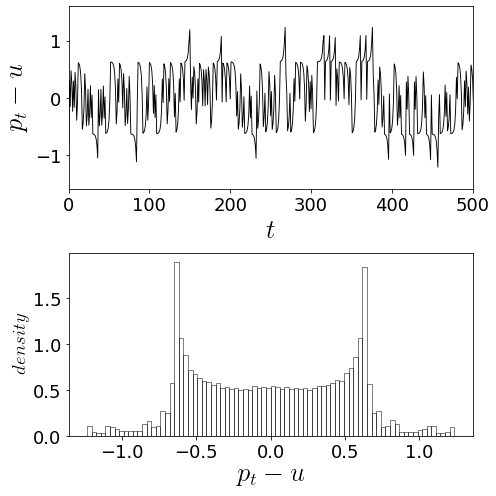

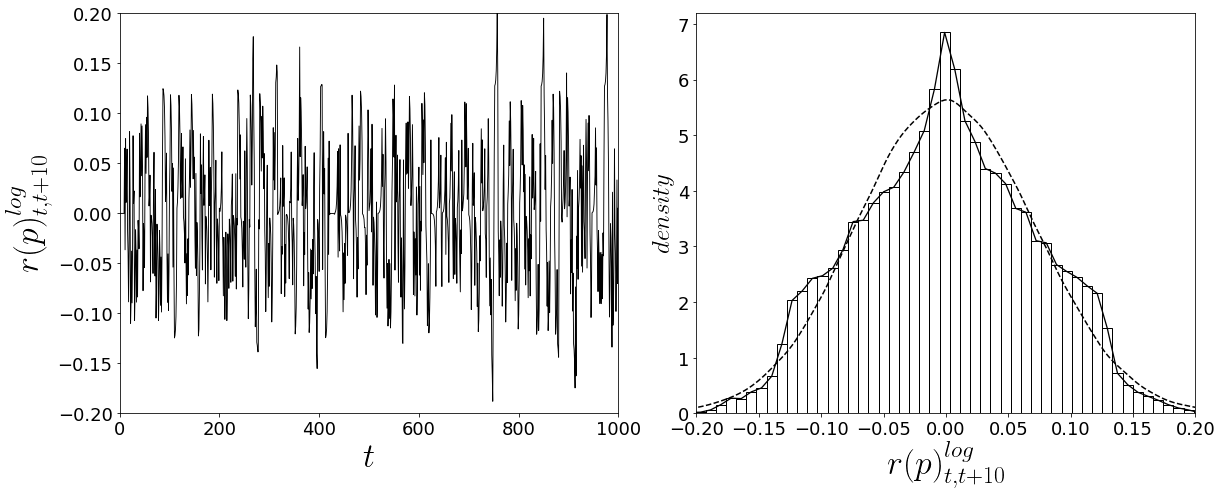

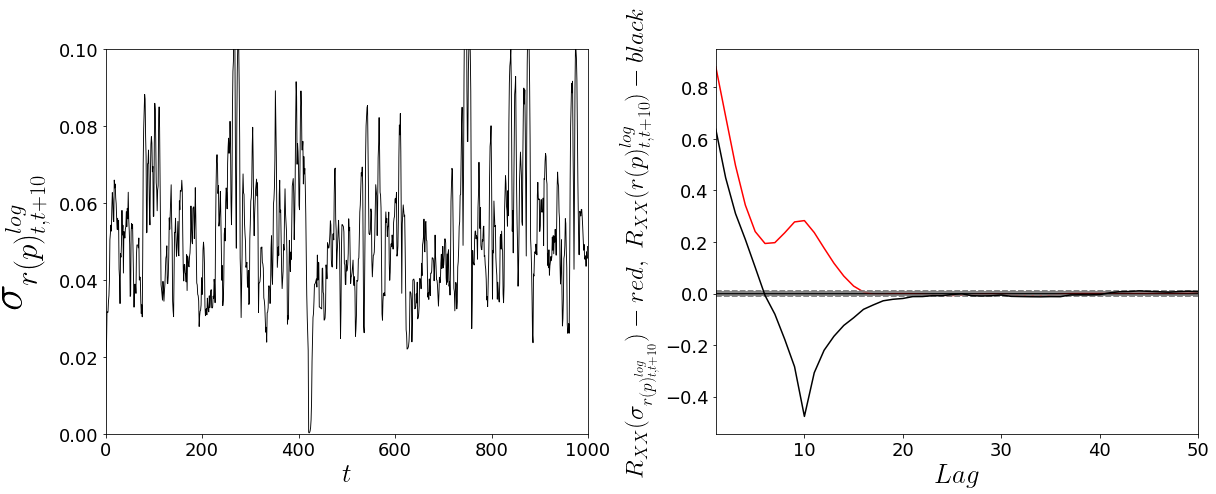

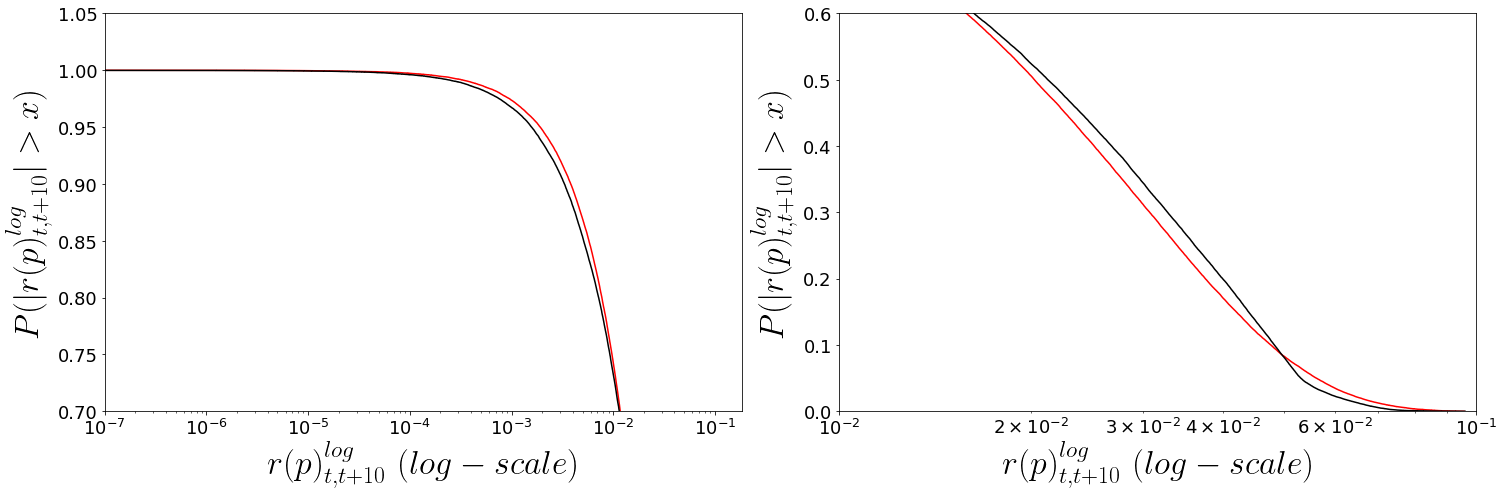

In [2]:
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import t

plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 

fs=27
# set model parameters
u=0
m=1
μ=2
α=0.115
β=0.102
#α=0.4
#a=1.001
#a2=a
#a,a2=1.01,1.01
a,a2=1.1,1.1
pmin,pmax=-1.6,1.6
T0=100000

lw2=0.9
c1='k'
τ=np.arange(0,T0,1)
p_0=1.5

def m_avg(x,l):
    avg=np.zeros(len(x)-l)
    for i in range(len(avg)):
        avg[i]=sum(x[i:i+l])/l
    return avg[avg!=0]

def m_std(x,l):
    std=np.zeros(len(x)-l)
    for i in range(len(std)):
        std[i]=np.std(x[i:i+l])
    return std

def returns(x,l):
    returns=np.zeros(len(x))
    for i in range(l,len(x)):
        returns[i]=(x[i]-x[i-l])/x[i-l]
    return returns

def log_returns(x,l):
    returns=np.zeros(len(x))
    for i in range(l,len(x)):
        returns[i]=ln(x[i]/x[i-l])
    return returns
        


data2=time_series(10,m,α,β,μ,T0,9,a,a2)
l=16
returns102=log_returns(data2,10)
std_ret=np.std(returns102)
mean_ret=np.mean(returns102)


normal_sim1=np.random.normal(mean_ret,std_ret,len(returns102))
normal_sim=normal_sim1[(normal_sim1 >min(returns102)) & (normal_sim1 <max(returns102))]

G =data2-10*np.ones(T0)
split1_N=normal_sim[normal_sim<0]
split2_N=normal_sim[normal_sim>0]
split1_S=returns102[returns102<0]
split2_S=returns102[returns102>0]

fig,(ax,ax1)=plt.subplots(2,1,figsize=(7,7))
ax.plot(τ,G,lw=lw2,c=c1)

ax.set_xlim(0,500)

sns.histplot(G,bins=80,stat="density",fill=False,
             color='k',ax=ax1)
ax1.set_ylabel(r'$density$',size=19,usetex=True)
ax.set_ylabel(r'$p_t-u$',size=fs,usetex=True)
ax.set_xlabel(r'$t$',size=fs,usetex=True)
ax1.set_xlabel(r'$p_t-u$',size=fs,usetex=True)


ax.set_ylim(pmin,pmax)
plt.tight_layout()
plt.savefig('dist.jpg')




std_ret=m_std(returns102,10)
k=1000
fig,([ax1,ax6])=plt.subplots(1,2,figsize=(17,7))
ax1.plot((np.arange(0,len(returns102),1))[:k],returns102[:k],'k',lw=0.9) 
ax1.set_xlim(0,k)
ax1.set_ylim(-0.2,0.2)
sns.histplot(returns102,bins=60,stat="density",fill=False,
             color='k',lw=1,ax=ax6)
sns.histplot(returns102,bins=60,stat="density",fill=False,element="poly",
             color='k',lw=1.3,ax=ax6)
sns.kdeplot(normal_sim,fill=False,           
             color='k',linestyle='--',ax=ax6)

ax6.set_ylabel(r'$density$',size=25,usetex=True)
ax6.set_xlabel(r'$r(p)_{t,t+10}^{log}$',size=fs+7,usetex=True)

ax6.set_xlim(-0.2,0.2)
ax1.set_ylabel(r'$r(p)_{t,t+10}^{log}$',size=fs+7,usetex=True)
ax1.set_xlabel(r'$t$',size=fs+7,usetex=True)


plt.tight_layout()
plt.savefig('ReturnDist.jpg')

fig,(ax2,ax5)=plt.subplots(1,2,figsize=(17,7))
ax2.plot((np.arange(0,len(std_ret),1))[:k],std_ret[:k],'k',lw=0.9)
ax2.set_xlim(0,k)
ax2.set_ylim(0,0.1)
pd.plotting.autocorrelation_plot(std_ret,color='r',ax=ax5)
pd.plotting.autocorrelation_plot(returns102,color='k',ax=ax5)
#x = np.linspace(-0.2,0.2, 100)
#ax6.plot(x, t.pdf(x,0.3,loc=0,scale=1/30),
       #'r', lw=1, alpha=1, label='t pdf')

ax5.set_title('')
ax5.set_xlim(1,50)

ax2.set_ylabel(r'$\sigma_{r(p)_{t,t+10}^{log}}$',size=45,usetex=True)
ax2.set_xlabel(r'$t$',size=fs,usetex=True)
ax5.set_ylabel(r'$R_{XX}(\sigma_{r(p)_{t,t+10}^{log}})-red, \ R_{XX}(r(p)_{t,t+10}^{log})- black $',size=25,usetex=True)
ax5.set_xlabel(r'$Lag$',size=fs,usetex=True)


plt.tight_layout()
plt.savefig('AutoC.jpg')


fig,(ax,ax2)=plt.subplots(1,2,figsize=(21,7))
sns.ecdfplot(

    data=np.abs(normal_sim)+np.ones(len(normal_sim)),
    log_scale=True,
    complementary=True, stat="proportion",color='r',ax=ax
)
sns.ecdfplot(

    data=np.abs(returns102)+np.ones(len(returns102)),
    log_scale=True, 
    complementary=True, stat="proportion",color='k',ax=ax
)
sns.ecdfplot(
    data=np.abs(normal_sim)+np.ones(len(normal_sim)),
    log_scale=True,
    complementary=True, stat="proportion",color='r',ax=ax2
)
sns.ecdfplot(

    data=np.abs(returns102)+np.ones(len(returns102)),
    log_scale=True, 
    complementary=True, stat="proportion",color='k',ax=ax2
)

ax.set_ylabel(r'$P(|r^{log}|>x)$',size=fs+7,usetex=True)

ax.set_xlabel(r'$r(p)_{t,t+10}^{log} \ (log-scale)$',size=fs+7,usetex=True)
ax.set_ylabel(r'$P(|r(p)_{t,t+10}^{log}|>x)$',size=fs+7,usetex=True)
ax2.set_ylabel(r'$P(|r(p)_{t,t+10}^{log}|>x)$',size=fs+7,usetex=True)
ax2.set_xlabel(r'$r(p)_{t,t+10}^{log} \ (log-scale)$',size=fs+7,usetex=True)


ax.set_ylim(0.7,1.05)
ax2.set_xlim(0.01,0.1)
ax2.set_ylim(0,0.6)

plt.tight_layout()
plt.savefig('CumulDist.jpg')



from scipy.stats import moment
M1=moment(data2, moment=[1, 2, 3, 4 ])
M2=moment(returns102, moment=[1, 2, 3, 4])
print(M1)
print(M2)




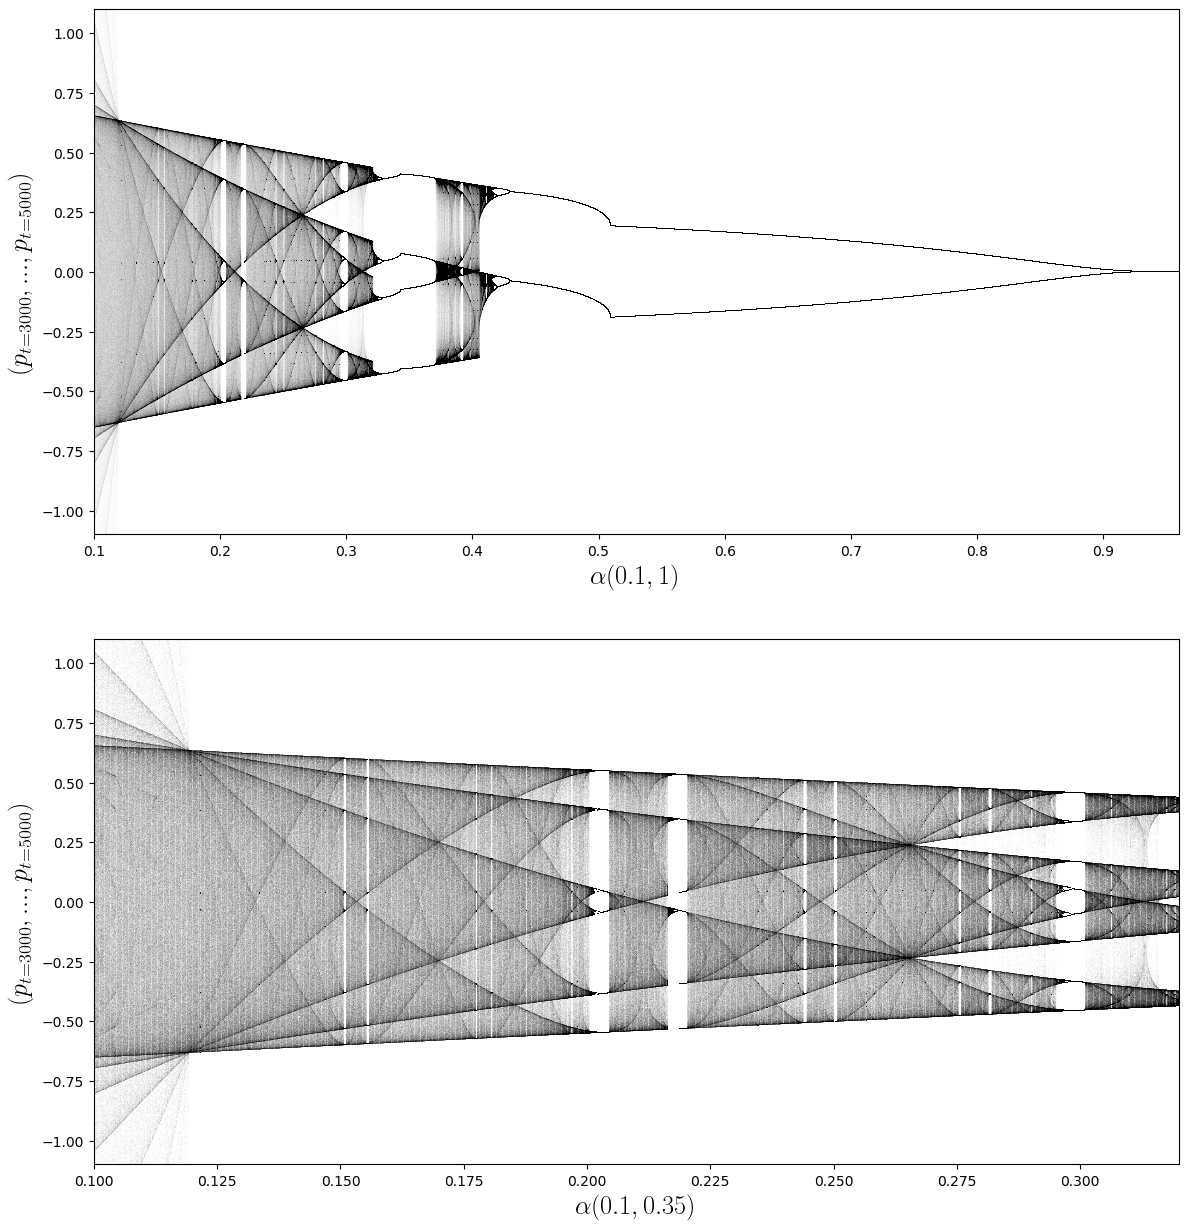

In [29]:
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
# bifurcation diagram of price adjustment process with aproximated Lyapunov exponent of the system
T1=5000

plt.style.use('default')

fig,(ax,ax2)=plt.subplots(2,1,figsize=(14,15))
n=12000
last=2000
α_lbound,α_ubound= 0.1,0.96
α_space=np.linspace(0.1,0.96,n)
data_matrix=np.zeros([n,T1])
#lyapunov=np.zeros(n)
for i in range(len(α_space)):
    data_matrix[i,:] =time_series(u,m,α_space[i],β,μ,T1,p_0,a,a2)
    #lyapunov[i]=Lyap(data_matrix[i,:],u,m,α_space[i],β,μ,a,a2)
for j in range((T1-last),T1):
    ax.plot(α_space,data_matrix[:,j],',k', alpha= .005)
    #ax1.plot(α_space, lyapunov,',k', alpha= .8)
    ax2.plot(α_space,data_matrix[:,j],',k', alpha= .02)
   

ax.set_xlim(α_lbound,α_ubound)
#ax1.set_xlim(α_lbound,α_ubound)
ax2.set_xlim(0.1,0.32)

ax.set_ylim(-1.1,1.1)
#ax1.set_ylim(-1.5,1.5)
ax2.set_ylim(-1.1,1.1)

ax.set_xlabel(r'$\alpha (0.1,1)$',size=19,usetex=True)
ax2.set_xlabel(r'$\alpha (0.1,0.35)$',size=19,usetex=True)

ax.set_ylabel(r'$(p_{t=3000},...,p_{t=5000})$',size=19,usetex=True)
ax2.set_ylabel(r'$(p_{t=3000},...,p_{t=5000})$',size=19,usetex=True)
#print(lyapunov)

plt.savefig('BifurcationDiagramII.jpg')

Text(0, 0.5, '$(p_{t=3000},...,p_{t=5000})$')

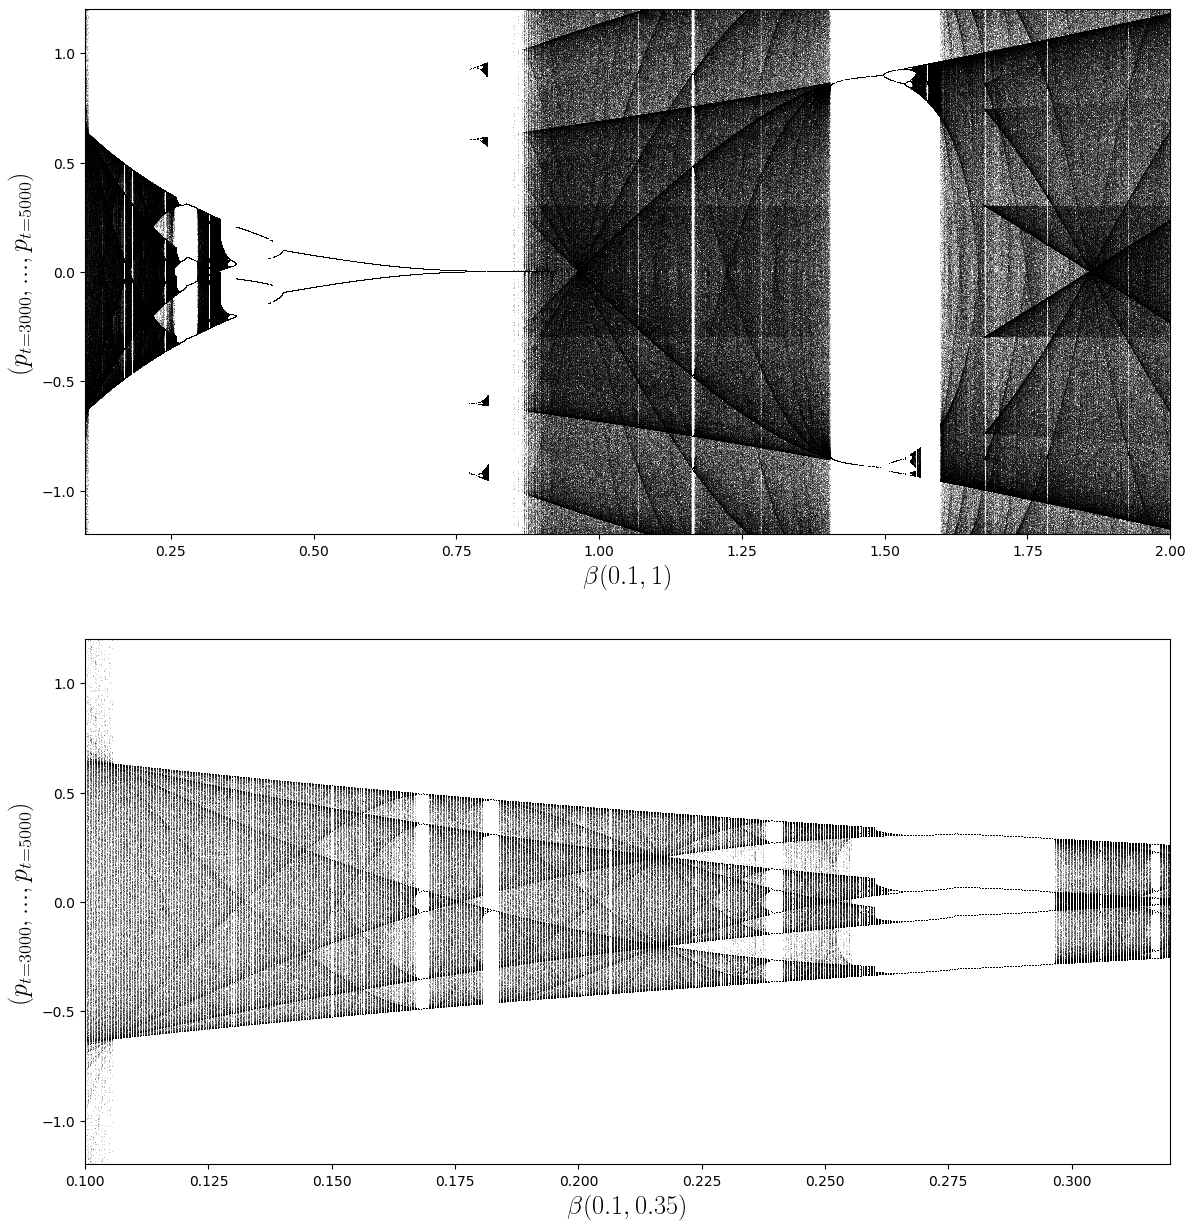

In [7]:
u=0
m=1
μ=2
α=0.115
β=0.102
a,a2=1.1,1.1
p_0=1.5

plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
# bifurcation diagram of price adjustment process with aproximated Lyapunov exponent of the system
T1=2000

plt.style.use('default')

fig,(ax,ax2)=plt.subplots(2,1,figsize=(14,15))
n=6000
last=1000
β_lbound,β_ubound= 0.1,2
β_space=np.linspace(0.1,2,n)
data_matrix=np.zeros([n,T1])
#lyapunov=np.zeros(n)
for i in range(len(β_space)):
    data_matrix[i,:] =time_series(u,m,α,β_space[i],μ,T1,p_0,a,a2)
    #lyapunov[i]=Lyap(data_matrix[i,:],u,m,α_space[i],β,μ,a,a2)
for j in range((T1-last),T1):
    ax.plot(β_space,data_matrix[:,j],',k', alpha= .2)
    #ax1.plot(α_space, lyapunov,',k', alpha= .8)
    ax2.plot(β_space,data_matrix[:,j],',k', alpha= .2)
   

ax.set_xlim(β_lbound,β_ubound)
#ax1.set_xlim(α_lbound,α_ubound)
ax2.set_xlim(0.1,0.32)

ax.set_ylim(-1.2,1.2)
#ax1.set_ylim(-1.5,1.5)
ax2.set_ylim(-1.2,1.2)

ax.set_xlabel(r'$\beta (0.1,1)$',size=19,usetex=True)
ax2.set_xlabel(r'$\beta (0.1,0.35)$',size=19,usetex=True)

ax.set_ylabel(r'$(p_{t=3000},...,p_{t=5000})$',size=19,usetex=True)
ax2.set_ylabel(r'$(p_{t=3000},...,p_{t=5000})$',size=19,usetex=True)
#print(lyapunov)



C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\ipykernel_launcher.py:102: RuntimeWarning: overflow encountered in double_scalars


Text(0, 0.5, '$(p_{t=3000},...,p_{t=5000})$')

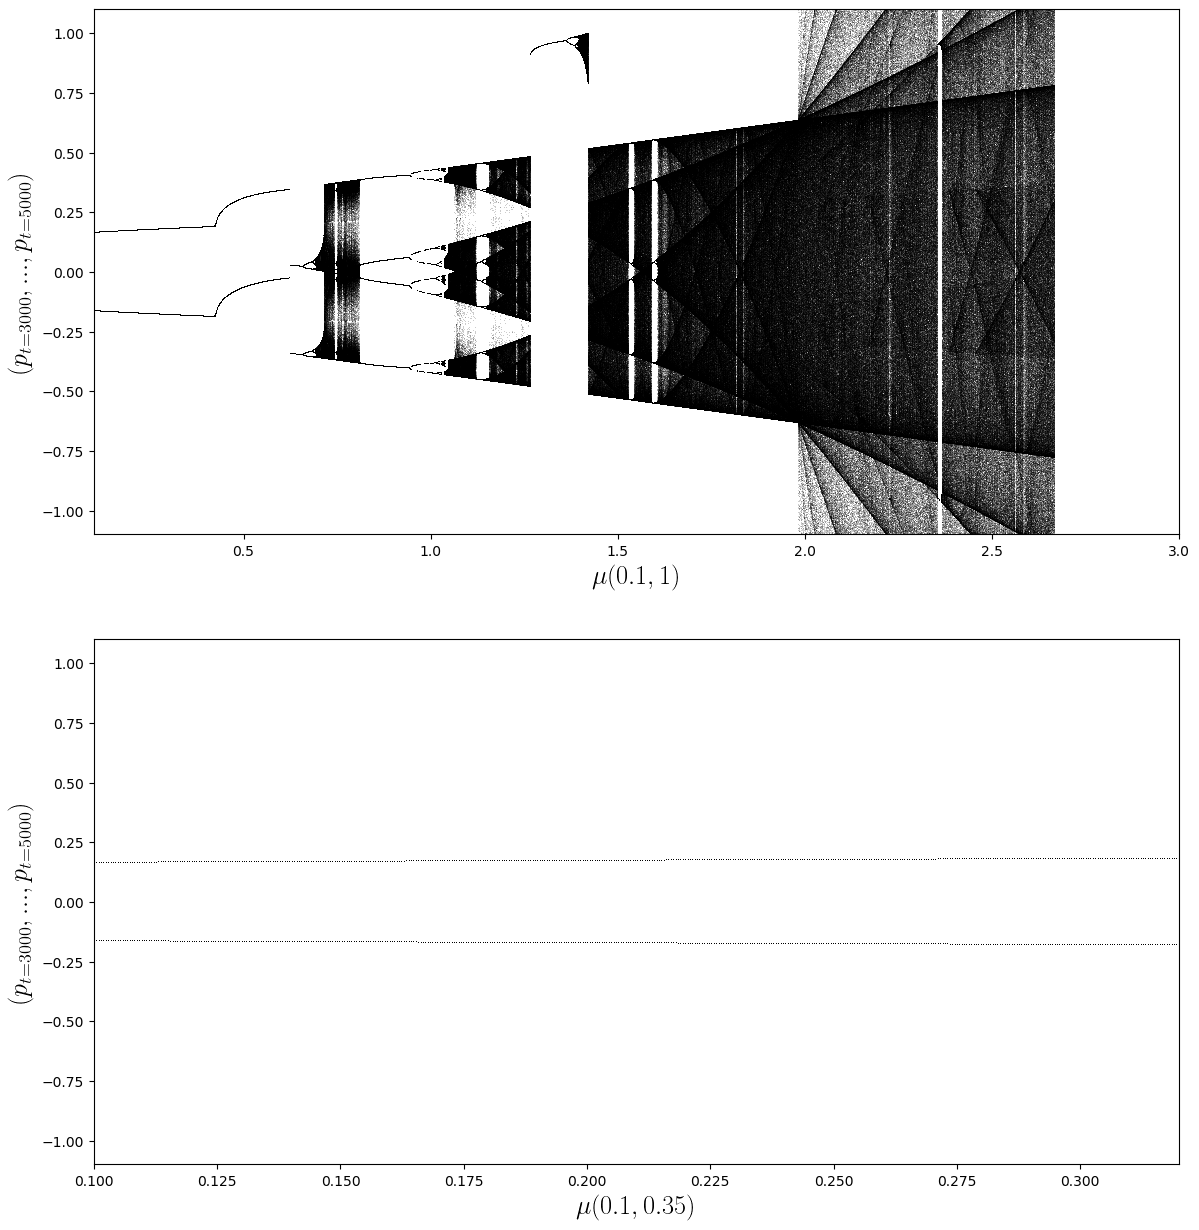

In [6]:
u=0
m=1
μ=2
α=0.115
β=0.102
a,a2=1.1,1.1
p_0=1.5

plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
# bifurcation diagram of price adjustment process with aproximated Lyapunov exponent of the system
T1=2000

plt.style.use('default')

fig,(ax,ax2)=plt.subplots(2,1,figsize=(14,15))
n=6000
last=1000
μ_lbound,μ_ubound= 0.1,3
μ_space=np.linspace(0.1,3,n)
data_matrix=np.zeros([n,T1])
#lyapunov=np.zeros(n)
for i in range(len(μ_space)):
    data_matrix[i,:] =time_series(u,m,α,β,μ_space[i],T1,p_0,a,a2)
    #lyapunov[i]=Lyap(data_matrix[i,:],u,m,α_space[i],β,μ,a,a2)
for j in range((T1-last),T1):
    ax.plot(μ_space,data_matrix[:,j],',k', alpha= .2)
    #ax1.plot(α_space, lyapunov,',k', alpha= .8)
    ax2.plot(μ_space,data_matrix[:,j],',k', alpha= .2)
   

ax.set_xlim(μ_lbound,μ_ubound)
#ax1.set_xlim(α_lbound,α_ubound)
ax2.set_xlim(0.1,0.32)

ax.set_ylim(-1.1,1.1)
#ax1.set_ylim(-1.5,1.5)
ax2.set_ylim(-1.1,1.1)

ax.set_xlabel(r'$\mu (0.1,1)$',size=19,usetex=True)
ax2.set_xlabel(r'$\mu (0.1,0.35)$',size=19,usetex=True)

ax.set_ylabel(r'$(p_{t=3000},...,p_{t=5000})$',size=19,usetex=True)
ax2.set_ylabel(r'$(p_{t=3000},...,p_{t=5000})$',size=19,usetex=True)
#print(lyapunov)


C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\ipykernel_launcher.py:102: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overflow encountered in double_scalars
 

C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overf

C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overf

C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overf

C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overf

C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overf

C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overf

C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overf

C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overf

C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overf

C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encount

C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encount

C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overf

C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overf

C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overf

C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overf

C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encount

C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encount

C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encount

C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overf

C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overf

C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encount

C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\transforms.py:2832: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
C:\Users\Illichmann_skolni\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2477: RuntimeWarning: overf

Text(0, 0.5, '$(p_{t=3000},...,p_{t=5000})$')

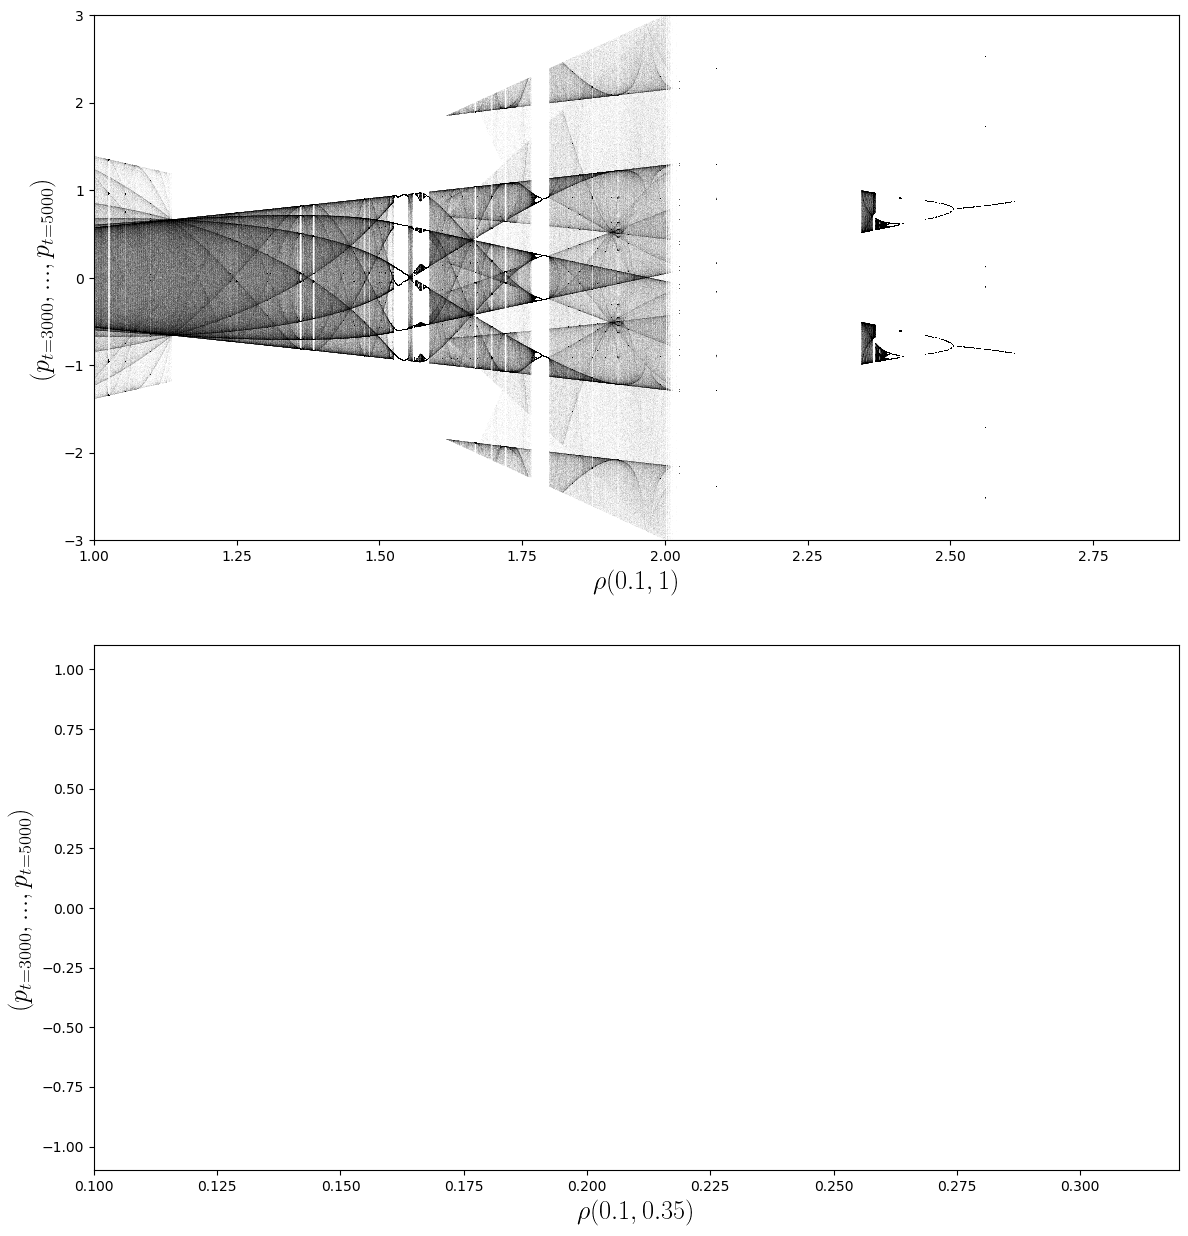

In [14]:
u=0
m=1
μ=2
α=0.115
β=0.102
a=1.1,1.1
p_0=1.5

plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
# bifurcation diagram of price adjustment process with aproximated Lyapunov exponent of the system
T1=2000

plt.style.use('default')

fig,(ax,ax2)=plt.subplots(2,1,figsize=(14,15))
n=6000
last=1000
μ_lbound,μ_ubound= 1,2.9
a_space=np.linspace(1,2.9,n)
data_matrix=np.zeros([n,T1])
#lyapunov=np.zeros(n)
for i in range(len(a_space)):
    data_matrix[i,:] =time_series(u,m,α,β,μ,T1,p_0,a_space[i],a_space[i])
    #lyapunov[i]=Lyap(data_matrix[i,:],u,m,α_space[i],β,μ,a,a2)
for j in range((T1-last),T1):
    ax.plot(a_space,data_matrix[:,j],',k', alpha= .02)
    #ax1.plot(α_space, lyapunov,',k', alpha= .8)
    #ax2.plot(a_space,data_matrix[:,j],',k', alpha= .2)
   

ax.set_xlim(μ_lbound,μ_ubound)
#ax1.set_xlim(α_lbound,α_ubound)
ax2.set_xlim(0.1,0.32)

ax.set_ylim(-3,3)
#ax1.set_ylim(-1.5,1.5)
ax2.set_ylim(-1.1,1.1)

ax.set_xlabel(r'$\rho (0.1,1)$',size=19,usetex=True)
ax2.set_xlabel(r'$\rho (0.1,0.35)$',size=19,usetex=True)

ax.set_ylabel(r'$(p_{t=3000},...,p_{t=5000})$',size=19,usetex=True)
ax2.set_ylabel(r'$(p_{t=3000},...,p_{t=5000})$',size=19,usetex=True)
#print(lyapunov)

15


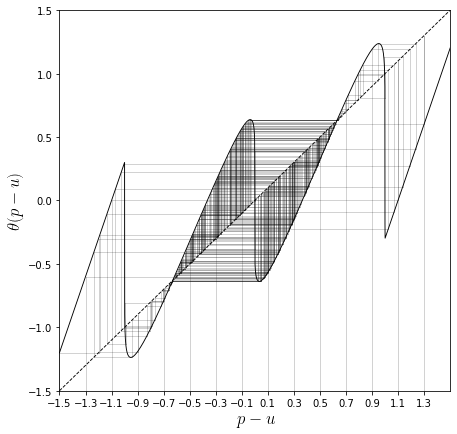

In [12]:
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 

u=0
m=1
μ=2
α=0.115
β=0.102
# initial condition, number of iterations
iterate=30
init=np.arange(-1.5,1.5,0.2)
pmin,pmax=-1.6,1.6
step=0.001
p= np.arange(pmin,pmax,step)

# plot cobweb diagrams
fig,(ax)=plt.subplots(1,1,figsize=(7,7))
ax.plot(p,θ(p,u,m,α,β,μ,a,a2),lw=lw2,c=c1)
ax.plot(p,p,lw=lw2,c=c1,linestyle='--')

for j in range(len(init)):
    x=init[j]
    for i in range(1,iterate):
        y= θ(x,u,m,α,β,μ,a,a2)
        if i==1:
            ax.plot([x, x],[x,-1.6], 'k', lw=0.7,alpha=0.25)
        if i>1:
            ax.plot([x, x], [x, y], 'k', lw=0.7,alpha=0.25)
            ax.plot([x, y], [y, y], 'k', lw=0.7,alpha=0.25)
            x = y

ax.set_ylabel(r'$ \theta(p-u) $',size=17,usetex=True)
ax.set_xlabel(r'$p-u$',size=17,usetex=True)            
#ax.title.set_text('cobweb plot for various initial conditions')
ax.set_xticks(init)
lim1,lim2=-1.5,1.5
ax.set_xlim(lim1,lim2)
ax.set_ylim(lim1,lim2)
plt.savefig('cobwebB.jpg')
print(len(init))

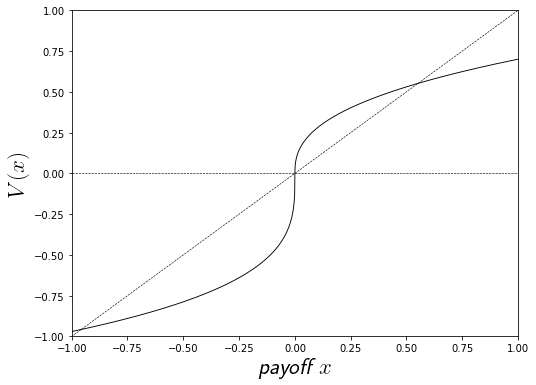

In [12]:
def π(β,β1,a,a1,p,u):
    check=isinstance(p,np.ndarray)
    if check==True:
        π=np.zeros(len(p))
        for i in range(len(p)):
            if p[i]-u<=0:
                π[i]= -a1*(abs(p[i]-u))**β1
            if p[i]-u>0:
                π[i]= +a*(abs(p[i]-u))**β
        return π
    if check==False:
        if p-u<0:
            π= (abs(p-u))**β
        if p-u>0:
            π= -(abs(p-u))**β
        return π
    
β,β1=0.4,0.3
a1,a=0.97,0.7
h=0.001
fig,(ax)=plt.subplots(1,1,figsize=(8,6))
x=np.arange(-100,100,h)
ax.plot(x,π(β,β1,a,a1,x,u),'k',lw=0.9)
ax.plot(x,x,'k',lw=0.6,linestyle='--')

ax.axhline([0],color='k',lw=0.6,linestyle='--')

ax.set_xlim(-1,1)
ax.set_ylim(-1,1)

ax.set_xlabel(r'$\textit{payoff} \-\ x$',size=23,usetex=True)
ax.set_ylabel(r'$V(x)$',size=23,usetex=True)


plt.savefig('ValueFunction.jpg')

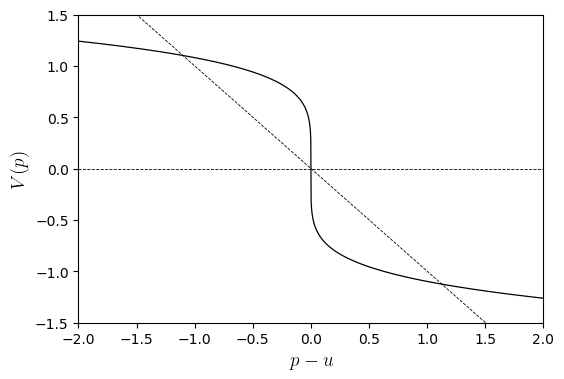

In [21]:
def π(β,p,u,a,a2):
    check=isinstance(p,np.ndarray)
    π=np.zeros(len(p))
    if check==True:
        for i in range(len(p)):
            if p[i]-u<=0:
                π[i]= a*(abs(p[i]-u))**β
            if p[i]-u>0:
                π[i]= -a2*(abs(p[i]-u))**β
    return π

u=0
β=0.2
a,a2=1.08,1.1  
h=0.001

x=np.arange(-2,2,h)

fig,(ax)=plt.subplots(1,1,figsize=(6,4))
ax.plot(x,π(β,x,u,a,a2),'k',lw=0.9)
ax.plot(x,-x,'k',lw=0.6,linestyle='--')

ax.axhline([0],color='k',lw=0.6,linestyle='--')

ax.set_xlim(-2,2)
ax.set_ylim(-1.5,1.5)
ax.set_xlabel(r'$p-u$',size=14,usetex=True)
ax.set_ylabel(r'$V(p)$',size=14,usetex=True)

plt.savefig('ValueFunctionB.jpg')